In [ ]:
#import semua library yang dibutuhkan

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Pastikan stopwords bahasa Indonesia tersedia
from nltk.corpus import stopwords
import nltk

#kebutuhan fetching kamus sentimen dari github
import csv
import requests
from io import StringIO

#visualisasi
import matplotlib.pyplot as plt

#persiapan analisis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#lib model
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# Load dataset
file_path = "review_game_genshin.csv"  # Path ke file CSV yang berisi data ulasan aplikasi
app_reviews_df = pd.read_csv(file_path)

# Menampilkan lima baris pertama dari DataFrame app_reviews_df
app_reviews_df.head()

,userName,content,score,reviewCreatedVersion,at,appVersion
0,Pengguna Google,"Visual cukup memanjakan mata, salah satu game ...",5,5.4.0_30057195_30231699,2025-02-12 07:39:48,5.4.0_30057195_30231699
1,Pengguna Google,Segi Quest Oke Tapi Pas Main agak Frame Drop k...,5,5.5.0_31400259_31451966,2025-04-07 17:44:48,5.5.0_31400259_31451966
2,Pengguna Google,Untuk sejauh ini sudah beragam serta adanya 7 ...,3,5.5.0_31400259_31451966,2025-04-07 22:59:33,5.5.0_31400259_31451966
3,Pengguna Google,"bagus cuman menurut ku quest nya bosenin, dan ...",4,5.5.0_31400259_31451966,2025-04-08 06:52:29,5.5.0_31400259_31451966
4,Pengguna Google,Beberapa teman mengalami cutscene patah-patah ...,5,5.5.0_31400259_31451966,2025-04-08 14:19:24,5.5.0_31400259_31451966


In [7]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              30000 non-null  object
 1   content               30000 non-null  object
 2   score                 30000 non-null  int64 
 3   reviewCreatedVersion  20813 non-null  object
 4   at                    30000 non-null  object
 5   appVersion            20813 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


In [8]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang
clean_df = app_reviews_df.dropna()

# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()
 
# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

#cek jumlah baris dan kolom setelah menghapus duplikat
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20813 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              20813 non-null  object
 1   content               20813 non-null  object
 2   score                 20813 non-null  int64 
 3   reviewCreatedVersion  20813 non-null  object
 4   at                    20813 non-null  object
 5   appVersion            20813 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


In [9]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text):
    try:
        return word_tokenize(text)
    except Exception as e:
        print(f"Error in tokenizingText: {e}")
        return []
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {"yg": "yang", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "gk": "tidak", "gitu": "begitu", "bkn": "bukan", "klo": "kalau", "kya": "seperti", "kpn": "kapan", "kmn": "kemana", "kmu": "kamu", "sama": "dengan", "aja": "saja", "nih": "ini", "lah": "tapi", "ku": "aku", "lo": "kamu", "lu": "kamu"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [10]:
try:
    _ = stopwords.words('indonesian')
except LookupError:
    nltk.download('stopwords')

# Pipeline preprocessing teks
# Clean the text and store it in the 'text_clean' column
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Convert text to lowercase and store it in 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Replace slang words with standard words and store in 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Tokenize the text and store it in 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Remove stopwords and store the result in 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Combine tokens into sentences and store in 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

#menampilkan hasil cleaning
clean_df

,userName,content,score,reviewCreatedVersion,at,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Pengguna Google,"Visual cukup memanjakan mata, salah satu game ...",5,5.4.0_30057195_30231699,2025-02-12 07:39:48,5.4.0_30057195_30231699,Visual cukup memanjakan mata salah satu game o...,visual cukup memanjakan mata salah satu game o...,visual cukup memanjakan mata salah satu game o...,"[visual, cukup, memanjakan, mata, salah, satu,...","[visual, memanjakan, mata, salah, game, open, ...",visual memanjakan mata salah game open world p...
1,Pengguna Google,Segi Quest Oke Tapi Pas Main agak Frame Drop k...,5,5.5.0_31400259_31451966,2025-04-07 17:44:48,5.5.0_31400259_31451966,Segi Quest Oke Tapi Pas Main agak Frame Drop k...,segi quest oke tapi pas main agak frame drop k...,segi quest oke tapi pas main agak frame drop k...,"[segi, quest, oke, tapi, pas, main, agak, fram...","[segi, quest, oke, pas, main, frame, drop, set...",segi quest oke pas main frame drop settingan g...
2,Pengguna Google,Untuk sejauh ini sudah beragam serta adanya 7 ...,3,5.5.0_31400259_31451966,2025-04-07 22:59:33,5.5.0_31400259_31451966,Untuk sejauh ini sudah beragam serta adanya e...,untuk sejauh ini sudah beragam serta adanya e...,untuk sejauh ini sudah beragam serta adanya el...,"[untuk, sejauh, ini, sudah, beragam, serta, ad...","[beragam, elemen, berbeda, beragam, team, part...",beragam elemen berbeda beragam team party elem...
3,Pengguna Google,"bagus cuman menurut ku quest nya bosenin, dan ...",4,5.5.0_31400259_31451966,2025-04-08 06:52:29,5.5.0_31400259_31451966,bagus cuman menurut ku quest nya bosenin dan j...,bagus cuman menurut ku quest nya bosenin dan j...,bagus cuman menurut aku quest nya bosenin dan ...,"[bagus, cuman, menurut, aku, quest, nya, bosen...","[bagus, cuman, quest, bosenin, quest, cerita, ...",bagus cuman quest bosenin quest cerita primo d...
4,Pengguna Google,Beberapa teman mengalami cutscene patah-patah ...,5,5.5.0_31400259_31451966,2025-04-08 14:19:24,5.5.0_31400259_31451966,Beberapa teman mengalami cutscene patahpatah s...,beberapa teman mengalami cutscene patahpatah s...,beberapa teman mengalami cutscene patahpatah s...,"[beberapa, teman, mengalami, cutscene, patahpa...","[teman, mengalami, cutscene, patahpatah, memai...",teman mengalami cutscene patahpatah memainkan ...
...,...,...,...,...,...,...,...,...,...,...,...,...
29993,Pengguna Google,Bagaimana cara menyelesaikan quest perjalanan ...,3,2.4.0_5199000_5224067,2022-01-27 20:32:28,2.4.0_5199000_5224067,Bagaimana cara menyelesaikan quest perjalanan ...,bagaimana cara menyelesaikan quest perjalanan ...,bagaimana cara menyelesaikan quest perjalanan ...,"[bagaimana, cara, menyelesaikan, quest, perjal...","[menyelesaikan, quest, perjalanan, tianqiu, ka...",menyelesaikan quest perjalanan tianqiu karakte...
29994,Pengguna Google,Bagus game nya bagi yg suka adventure pasti su...,5,2.1.0_3981765_4073622,2021-09-30 09:10:07,2.1.0_3981765_4073622,Bagus game nya bagi yg suka adventure pasti su...,bagus game nya bagi yg suka adventure pasti su...,bagus game nya bagi yang suka adventure pasti ...,"[bagus, game, nya, bagi, yang, suka, adventure...","[bagus, game, suka, adventure, suka]",bagus game suka adventure suka
29995,Pengguna Google,Lumayan seru dan agak susah juga quest nya unt...,4,2.3.0_4786731_4861639,2021-12-07 22:30:49,2.3.0_4786731_4861639,Lumayan seru dan agak susah juga quest nya unt...,lumayan seru dan agak susah juga quest nya unt...,lumayan seru dan agak susah juga quest nya unt...,"[lumayan, seru, dan, agak, susah, juga, quest,...","[lumayan, seru, susah, quest, pemulahehehee]",lumayan seru susah quest pemulahehehee
29997,Pengguna Google,"Grafik nya bagus bgt, game nya ga bosenin",5,3.3.0_11741873_11806263,2022-12-28 08:29:28,3.3.0_11741873_11806263,Grafik nya bagus bgt game nya ga bosenin,grafik nya bagus bgt game nya ga bosenin,grafik nya bagus banget game nya ga bosenin,"[grafik, nya, bagus, banget, game, nya, ga,

In [11]:
# Fungsi untuk mengambil kamus sentimen dari GitHub
def load_lexicon(url):
    lexicon = {}
    response = requests.get(url)
    
    if response.ok:
        data = StringIO(response.text)
        csv_reader = csv.reader(data)
        for word, score in csv_reader:
            lexicon[word] = int(score)
    else:
        print(f"Gagal memuat data dari: {url}")
    
    return lexicon

# URL kamus sentimen
url_positive = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
url_negative = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Muat kamus positif dan negatif
lexicon_positive = load_lexicon(url_positive)
lexicon_negative = load_lexicon(url_negative)

# Fungsi analisis sentimen berbasis lexicon
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan polaritas berdasarkan nilai skor
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [12]:
# Terapkan fungsi analisis sentimen ke kolom 'text_stopword'
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)

# Pisahkan hasil ke dalam dua kolom: skor dan polaritas
clean_df['polarity_score'], clean_df['polarity'] = zip(*results)

# Tampilkan jumlah data berdasarkan polaritas
print(clean_df['polarity'].value_counts())

polarity
negative    9785
positive    9207
neutral     1821
Name: count, dtype: int64


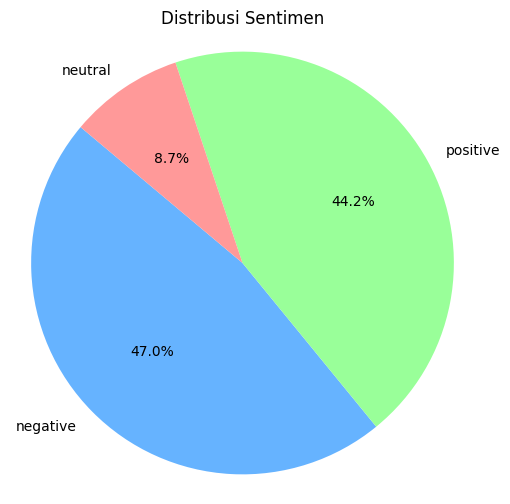

In [13]:
# Hitung jumlah masing-masing sentimen
sentiment_counts = clean_df['polarity'].value_counts()

# Buat pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Supaya lingkarannya bulat sempurna
plt.show()

In [14]:

# Memisahkan kolom teks dan label sentimen
fitur = clean_df['text_akhir']
label = clean_df['polarity']

# Mengubah teks menjadi representasi numerik dengan TF-IDF
vectorizer = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
fitur_tfidf = vectorizer.fit_transform(fitur)

# Konversi hasil vektorisasi menjadi DataFrame agar lebih mudah dibaca
df_fitur = pd.DataFrame(fitur_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Tampilkan beberapa baris awal dari hasil vektorisasi
print(df_fitur.head())

# Memisahkan data untuk pelatihan dan pengujian model
X_train, X_test, y_train, y_test = train_test_split(fitur_tfidf, label, test_size=0.2, random_state=42)

   akun  alur  ama  ampas   android  anniversary   ar   artefak     bagus  \
0   0.0   0.0  0.0    0.0  0.000000          0.0  0.0  0.000000  0.266272   
1   0.0   0.0  0.0    0.0  0.176402          0.0  0.0  0.000000  0.148527   
2   0.0   0.0  0.0    0.0  0.000000          0.0  0.0  0.366059  0.000000   
3   0.0   0.0  0.0    0.0  0.000000          0.0  0.0  0.000000  0.058756   
4   0.0   0.0  0.0    0.0  0.000000          0.0  0.0  0.000000  0.000000   

   banget  ...  trus  tuh  udah  udh  ulang    update     versi  wifi  \
0     0.0  ...   0.0  0.0   0.0  0.0    0.0  0.000000  0.000000   0.0   
1     0.0  ...   0.0  0.0   0.0  0.0    0.0  0.125072  0.193877   0.0   
2     0.0  ...   0.0  0.0   0.0  0.0    0.0  0.000000  0.000000   0.0   
3     0.0  ...   0.0  0.0   0.0  0.0    0.0  0.000000  0.000000   0.0   
4     0.0  ...   0.0  0.0   0.0  0.0    0.0  0.000000  0.000000   0.0   

      world  yah  
0  0.200210  0.0  
1  0.167516  0.0  
2  0.000000  0.0  
3  0.000000  0.0  
4  

In [15]:
# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB()
 
# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train.toarray(), y_train)
 
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())
 
# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)
 
# Menampilkan akurasi
print('Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Naive Bayes - accuracy_test:', accuracy_test_nb)

Naive Bayes - accuracy_train: 0.7047447447447448
Naive Bayes - accuracy_test: 0.6946913283689646


In [17]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()
 
# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)
 
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())
 
# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)
 
# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)
 
# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.7468468468468469
Logistic Regression - accuracy_test: 0.7343262070622147


In [19]:
# Membuat objek model Decision Tree
decision_tree = DecisionTreeClassifier()
 
# Melatih model Decision Tree pada data pelatihan
decision_tree.fit(X_train.toarray(), y_train)
 
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_dt = decision_tree.predict(X_train.toarray())
y_pred_test_dt = decision_tree.predict(X_test.toarray())
 
# Evaluasi akurasi model Decision Tree
accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)
 
# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Decision Tree - accuracy_train: 0.9845045045045046
Decision Tree - accuracy_test: 0.6130194571222676


In [21]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()
 
# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)
 
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())
 
# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)
 
# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9845045045045046
Random Forest - accuracy_test: 0.7086235887581072


In [25]:
# Inisialisasi model Support Vector Machine (SVM) dengan kernel linear
svm_model = LinearSVC()

# Latih model SVM dengan data training
svm_model.fit(X_train.toarray(), y_train)

# Prediksi hasil pada data training dan data testing
y_pred_train_svm = svm_model.predict(X_train.toarray())
y_pred_test_svm = svm_model.predict(X_test.toarray())

# Evaluasi performa model menggunakan akurasi
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Tampilkan hasil akurasi model SVM
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.7464264264264264
SVM - accuracy_test: 0.7333653615181359


In [29]:
# Inisialisasi model KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # kamu bisa ganti nilai K jika mau coba-coba

# Latih model dengan data pelatihan
knn_model.fit(X_train.toarray(), y_train)

# Prediksi pada data pelatihan dan data pengujian
y_pred_train_knn = knn_model.predict(X_train.toarray())
y_pred_test_knn = knn_model.predict(X_test.toarray())

# Evaluasi akurasi model
accuracy_train_knn = accuracy_score(y_pred_train_knn, y_train)
accuracy_test_knn = accuracy_score(y_pred_test_knn, y_test)

# Menampilkan akurasi
print('KNN - accuracy_train:', accuracy_train_knn)
print('KNN - accuracy_test:', accuracy_test_knn)


KNN - accuracy_train: 0.7169369369369369
KNN - accuracy_test: 0.5889983185202978


### Dalam hasil akhir, skor akurasi tertinggi diperoleh menggunakan model RANDOM FOREST dengan skor 0.98 untuk train, dan 0.70 untuk test